# MNIST Image Classification with TensorFlow on Cloud ML Engine

This notebook demonstrates how to implement a simple linear image models on MNIST using Estimator/Experiment.
<hr/>
This <a href="mnist_models.ipynb">companion notebook</a> extends the basic harness of this notebook to a variety of models including DNN, CNN, dropout, pooling etc.

In [36]:
import os
PROJECT = 'cloud-training-demos' # REPLACE WITH YOUR PROJECT ID
BUCKET = 'cloud-training-demos-ml' # REPLACE WITH YOUR BUCKET NAME
REGION = 'us-central1' # REPLACE WITH YOUR BUCKET REGION e.g. us-central1

# do not change these
os.environ['PROJECT'] = PROJECT
os.environ['BUCKET'] = BUCKET
os.environ['REGION'] = REGION

In [37]:
%bash
gcloud config set project $PROJECT
gcloud config set compute/region $REGION

Updated property [core/project].
Updated property [compute/region].


## Exploring the data

Let's download MNIST data and examine the shape. We will need these numbers ...

In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('mnist/data', one_hot=True, reshape=False)
print mnist.train.images.shape
print mnist.train.labels.shape

Extracting mnist/data/train-images-idx3-ubyte.gz
Extracting mnist/data/train-labels-idx1-ubyte.gz
Extracting mnist/data/t10k-images-idx3-ubyte.gz
Extracting mnist/data/t10k-labels-idx1-ubyte.gz
(55000, 28, 28, 1)
(55000, 10)


In [17]:
HEIGHT=28
WIDTH=28
NCLASSES=10

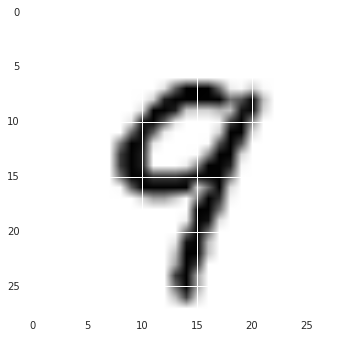

In [34]:
import matplotlib.pyplot as plt
IMGNO=12
plt.imshow(mnist.test.images[IMGNO].reshape(HEIGHT, WIDTH));

## Define the model.
Let's start with a very simple linear classifier. All our models will have this basic interface -- they will take an image and return logits.

In [8]:
def linear_model(img):
  X = tf.reshape(img, [-1, HEIGHT*WIDTH]) # flattened
  #W = tf.Variable(tf.zeros([HEIGHT*WIDTH, NCLASSES]))
  #b = tf.Variable(tf.zeros([NCLASSES]))
  W = tf.Variable(tf.truncated_normal([HEIGHT*WIDTH, NCLASSES], stddev=0.1))
  b = tf.Variable(tf.truncated_normal([NCLASSES], stddev=0.1))
  ylogits = tf.matmul(X, W) + b
  return ylogits, NCLASSES

## Write the harness

As usual, we need to specify input functions for training, evaluation, and predicition.

In [1]:
def make_train_input_fn(mnist):
  def input_fn():
    features, labels = tf.train.shuffle_batch(
                            [tf.constant(mnist.train.images), tf.constant(mnist.train.labels)],
                            batch_size=100, capacity=5000, min_after_dequeue=2000, enqueue_many=True)
    features = {'image': features}
    return features, labels
  return input_fn

def make_eval_input_fn(mnist):
  def input_fn():
    features, labels = tf.constant(mnist.test.images), tf.constant(mnist.test.labels)
    features = {'image': features}
    return features, labels
  return input_fn

def serving_input_fn():
    inputs = {'image': tf.placeholder(tf.float32, [None, HEIGHT, WIDTH])}
    features = inputs # as-is
    return tf.estimator.export.ServingInputReceiver(features, inputs)

I could have simply used a LinearClassifier, but later on, I will want to use different models, and so let's write a custom estimator

In [10]:
def image_classifier(features, labels, mode, params):
  ylogits, nclasses = linear_model(features['image'])
  probabilities = tf.nn.softmax(ylogits)
  classes = tf.cast(tf.argmax(probabilities, 1), tf.uint8)
  if mode == tf.estimator.ModeKeys.TRAIN or mode == tf.estimator.ModeKeys.EVAL:
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=ylogits, labels=tf.one_hot(labels, nclasses)))
    evalmetrics =  {'accuracy': tf.metrics.accuracy(classes, labels)}
    if mode == tf.estimator.ModeKeys.TRAIN:
      train_op = tf.contrib.layers.optimize_loss(loss, tf.train.get_global_step(),
                                                 learning_rate=params['learning_rate'], optimizer="Adam")
    else:
      train_op = None
  else:
    loss = None
    train_op = None
    evalmetrics = None
 
  return tf.estimator.EstimatorSpec(
        mode=mode,
        predictions={"probabilities": probabilities, "classes": classes},
        loss=loss,
        train_op=train_op,
        eval_metric_ops=evalmetrics,
        export_outputs={'classes': tf.estimator.export.PredictOutput({"probabilities": probabilities, "classes": classes})}
    )

def create_custom_estimator(output_dir, hparams):
  training_config = tf.contrib.learn.RunConfig(save_checkpoints_secs=None,
                                               save_checkpoints_steps=hparams['train_steps']/5)
  return tf.estimator.Estimator(model_fn=image_classifier, model_dir=output_dir, 
                                config=training_config, params=hparams)

Experiment is the class that does distributed training.

In [11]:
def make_experiment_fn(output_dir, data_dir, hparams):
  def experiment_fn(output_dir):
    mnist = input_data.read_data_sets(data_dir, reshape=False)  
    return tf.contrib.learn.Experiment(
      estimator=create_custom_estimator(output_dir, hparams),
      train_input_fn=make_train_input_fn(mnist),
      eval_input_fn=make_eval_input_fn(mnist),
      train_steps=hparams['train_steps'],
      eval_steps=1,
      min_eval_frequency=min(100,hparams['train_steps']/10),
      export_strategies=tf.contrib.learn.utils.saved_model_export_utils.make_export_strategy(serving_input_fn=serving_input_fn)
    )
  return experiment_fn

This is the main() function

In [ ]:
output_dir='mnist/learned'
hparams = {'train_steps': 100, 'learning_rate': 0.01}
tf.contrib.learn.learn_runner.run(make_experiment_fn(output_dir, 'mnist/data', hparams), output_dir)

## Run as a Python module

Let's run it as Python module

In [ ]:
%bash
rm -rf mnistmodel.tar.gz mnist_trained
export PYTHONPATH=${PYTHONPATH}:${PWD}/mnistmodel
python -m trainer.task \
   --output_dir=${PWD}/mnist_trained \
   --train_steps=10 --learning_rate=0.01 --job-dir=./tmp

Now, let's do it on ML Engine

In [ ]:
%bash
OUTDIR=gs://${BUCKET}/mnist/trained
JOBNAME=mnist_$(date -u +%y%m%d_%H%M%S)
echo $OUTDIR $REGION $JOBNAME
gsutil -m rm -rf $OUTDIR
gcloud ml-engine jobs submit training $JOBNAME \
   --region=$REGION \
   --module-name=trainer.task \
   --package-path=${PWD}/mnistmodel/trainer \
   --job-dir=$OUTDIR \
   --staging-bucket=gs://$BUCKET \
   --scale-tier=BASIC_GPU \
   --runtime-version=1.2 \
   -- \
   --output_dir=$OUTDIR \
   --train_steps=1000 --learning_rate=0.01

About ten minutes later, the job finished, and I got:
<pre>
Saving dict for global step 1000: accuracy = 0.9273, global_step = 1000, loss = 0.266696
</pre>
In other words, we achieved 93% accuracy with the simple linear model.

## Deploying and predicting with model

Deploy the model:

In [ ]:
%bash
MODEL_NAME="mnist"
MODEL_VERSION="v1"
MODEL_LOCATION=$(gsutil ls gs://${BUCKET}/mnist/trained/export/Servo | tail -1)
echo "Deleting and deploying $MODEL_NAME $MODEL_VERSION from $MODEL_LOCATION ... this will take a few minutes"
#gcloud ml-engine versions delete ${MODEL_VERSION} --model ${MODEL_NAME}
#gcloud ml-engine models delete ${MODEL_NAME}
gcloud ml-engine models create ${MODEL_NAME} --regions $REGION
gcloud ml-engine versions create ${MODEL_VERSION} --model ${MODEL_NAME} --origin ${MODEL_LOCATION}

To predict with the model, let's take one of the example images.

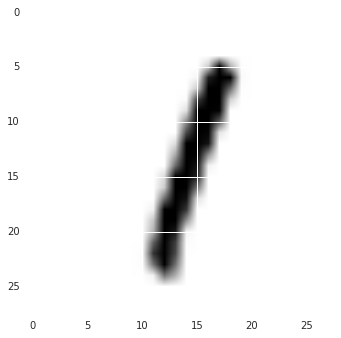

In [49]:
import json, codecs
import matplotlib.pyplot as plt
IMGNO=5
jsondata = {'image': [mnist.test.images[IMGNO].reshape(HEIGHT, WIDTH).tolist()]}
json.dump(jsondata, codecs.open('test.json', 'w', encoding='utf-8'))
plt.imshow(mnist.test.images[IMGNO].reshape(HEIGHT, WIDTH));

Send it to the prediction service

In [52]:
%bash
gcloud ml-engine predict --model=mnist --version=v1 --json-instances=./test.json

CLASSES  PROBABILITIES
1        [1.3500071283090165e-08, 0.99725741147995, 0.0007942980737425387, 0.0003019010182470083, 1.9881515527231386e-06, 9.06568493519444e-06, 1.3278344113132334e-06, 0.0010386130306869745, 0.0004955643089488149, 9.991202387027442e-05]


Here is another way to invoke the prediction service, this time from Python:

In [53]:
from googleapiclient import discovery
from oauth2client.client import GoogleCredentials
import json, codecs

credentials = GoogleCredentials.get_application_default()
api = discovery.build('ml', 'v1', credentials=credentials,
            discoveryServiceUrl='https://storage.googleapis.com/cloud-ml/discovery/ml_v1_discovery.json')

request_data = {'instances':
  [
      {
        'image': [mnist.test.images[IMGNO].reshape(HEIGHT, WIDTH).tolist()]
      }
     for IMGNO in [12, 5]
  ]
}

parent = 'projects/%s/models/%s/versions/%s' % (PROJECT, 'mnist', 'v1')
response = api.projects().predict(body=request_data, name=parent).execute()
print "response={0}".format(response)

response={u'predictions': [{u'probabilities': [4.8950860218610615e-06, 1.3094988204898073e-08, 6.579420733032748e-05, 0.0014328286051750183, 0.012759067118167877, 0.0007259113481268287, 2.268994421683601e-06, 0.040450677275657654, 0.002851910889148712, 0.941706657409668], u'classes': 9}, {u'probabilities': [1.3500071283090165e-08, 0.99725741147995, 0.0007942984811961651, 0.0003019010182470083, 1.9881515527231386e-06, 9.065693120646756e-06, 1.3278369124236633e-06, 0.001038614078424871, 0.0004955647746101022, 9.991212573368102e-05], u'classes': 1}]}


In [54]:
print [(pred['classes'], pred['probabilities'][pred['classes']]) for pred in response['predictions']]

[(9, 0.941706657409668), (1, 0.99725741147995)]


<pre>
# Copyright 2017 Google Inc. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
</pre>